<a href="https://colab.research.google.com/github/i-Shanky/DL_Implementations/blob/master/AutoEncoder_with_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q: 1.a. Implement a CNN in which the input is a noisy number and the output is a denoised number.
Use MNIST dataset. Use Gaussian distribution to add noise to the input. Plot the training & validation loss.

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model,Model
from keras.layers import Conv2D, Conv2DTranspose,Input,Flatten,Dense
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from imgaug import augmenters

In [0]:
# Model configuration
img_width, img_height = 28, 28
batch_size = 150
no_epochs = 10
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.55
number_of_visualizations = 6

In [0]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
# Reshape data based on channels first / channels last strategy.
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_width, img_height)
    X_test = X_test.reshape(X_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
    X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

In [6]:
input_shape

(28, 28, 1)

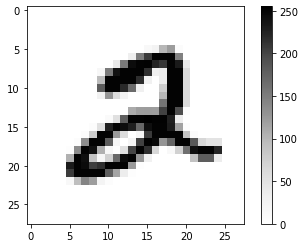

In [7]:
plt.figure()
plt.imshow(X_train[5].reshape(28,28),cmap='Greys')
plt.colorbar()
plt.show()

In [8]:
# Add noise
noise = augmenters.GaussianBlur(sigma=0.75)
seq = augmenters.Sequential([noise]) # apply augmenters in random order
noisy_input = seq.augment_images(X_train ) 
noisy_input_test = seq.augment_images(X_test )
noisy_input_test.shape

(10000, 28, 28, 1)

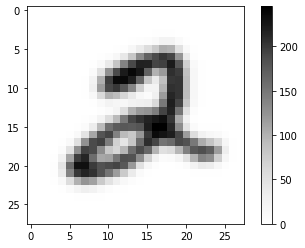

In [9]:
plt.figure()
plt.imshow(noisy_input[5].reshape(28,28),cmap='Greys')
plt.colorbar()
plt.show()

In [10]:
# Create the layers of the model
input_layer = Input(shape=input_shape)  #(28,28,1) 
#encoding
model = Sequential()
encoded_layer1 = Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(input_layer)
encoded_layer2 = Conv2D(32, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(encoded_layer1)
encoded_layer3 = Conv2D(16, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(encoded_layer2)
#decoding
decoded_layer1 = Conv2DTranspose(16, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(encoded_layer3)
decoded_layer2 = Conv2DTranspose(32, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(decoded_layer1)
decoded_layer3 = Conv2DTranspose(64, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform')(decoded_layer2)
output_layer = Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), padding='same')(decoded_layer3)

In [11]:
#Build the model
model = Model(input_layer, output_layer)
#Summary of the model
model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 16)        2320      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 32)        4640      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 64)        1849

In [13]:
#Compiling the model
model.compile(optimizer='adam', loss='mse')
history=model.fit(noisy_input,X_train,epochs=no_epochs,batch_size=batch_size,validation_split=validation_split)





Train on 48000 samples, validate on 12000 samples
Epoch 1/10





48000/48000 [==============================] - 503s 10ms/step - loss: 376.8342 - val_loss: 67.2850
Epoch 2/10
48000/48000 [==============================] - 502s 10ms/step - loss: 45.3618 - val_loss: 34.9428
Epoch 3/10
48000/48000 [==============================] - 501s 10ms/step - loss: 26.6205 - val_loss: 22.0586
Epoch 4/10
48000/48000 [==============================] - 505s 11ms/step - loss: 19.3237 - val_loss: 16.5050
Epoch 5/10
48000/48000 [==============================] - 502s 10ms/step - loss: 15.6539 - val_loss: 13.4116
Epoch 6/10
48000/48000 [==============================] - 500s 10ms/step - loss: 13.8263 - val_loss: 11.3321
Epoch 7/10
48000/48000 [==============================] - 499s 10ms/step - loss: 11.3601 - val_loss: 21.9613
Epoch 8/10
48000/48000 [==============================] - 501s 10ms/step - loss: 10.0365 - val_loss: 27.5488
Epoch 9/10
48000/48000 [==============================] - 501s 10ms/

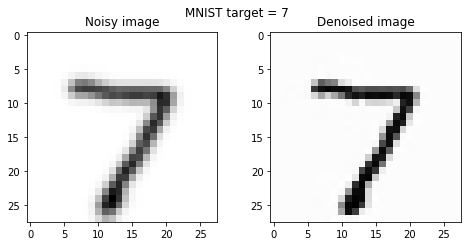

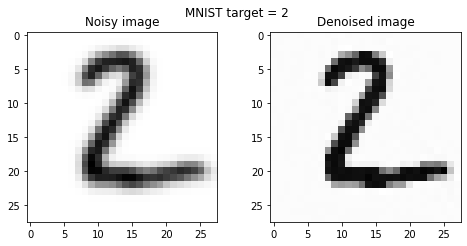

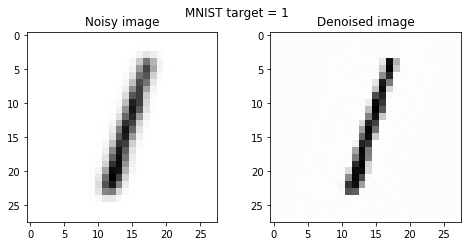

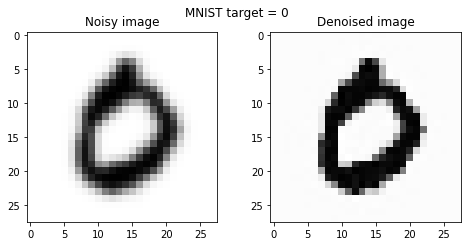

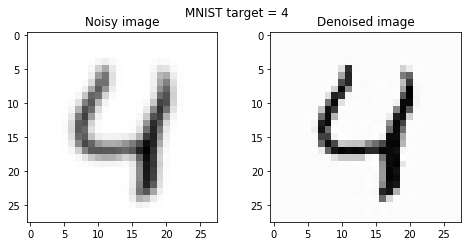

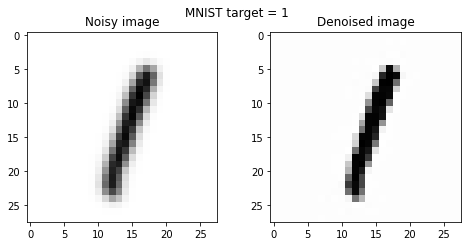

In [16]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = y_test[:number_of_visualizations]
denoised_images = model.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
#  pure_image  = input_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image,cmap='Greys')
  axes[0].set_title('Noisy image')
#  axes[1].imshow(pure_image,cmap='Greys')
#  axes[1].set_title('Pure image')
  axes[1].imshow(denoised_image,cmap='Greys')
  axes[1].set_title('Denoised image')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()

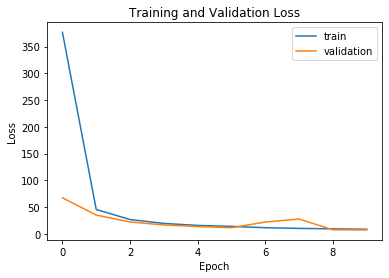

In [17]:
model.metrics_names
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
model.save('my_model.h5')

1.b. Build a classifier based on the trained Autoencoder. Extract the trained encoder and add some fully connected layers to classify the digits [Semi - Supervised Classification using Autoencoders].

In [0]:
model = load_model('my_model.h5')

In [20]:
model.load_weights('my_model.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 16)        2320      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 32)        4640      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 64)        1849

In [21]:
model.layers

In [0]:
#Using only the encoder layers of the Autoencoder
encoder_layers = []
for i in range(0,4):
  encoder_layers.append(model.layers[i])    

In [0]:
batch_size = 128
num_classes = 10
epochs = 5 
#Fresh input of data
(x_train,y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [53]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [38]:
newmodel = Sequential(encoder_layers)
newmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
_________________________________________________________________


In [0]:
newmodel.add(Flatten())
newmodel.add(Dense(128,activation='relu')) 
newmodel.add(Dense(10,activation='softmax'))

In [46]:
newmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

newmodel.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
score = newmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 220s 4ms/step - loss: 0.1863 - acc: 0.9455 - val_loss: 0.0577 - val_acc: 0.9802
Epoch 2/5
60000/60000 [==============================] - 220s 4ms/step - loss: 0.0433 - acc: 0.9863 - val_loss: 0.0561 - val_acc: 0.9829
Epoch 3/5
60000/60000 [==============================] - 221s 4ms/step - loss: 0.0243 - acc: 0.9924 - val_loss: 0.0541 - val_acc: 0.9843
Epoch 4/5
60000/60000 [==============================] - 221s 4ms/step - loss: 0.0133 - acc: 0.9961 - val_loss: 0.0528 - val_acc: 0.9863
Epoch 5/5
60000/60000 [==============================] - 221s 4ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 0.0677 - val_acc: 0.9865
Test loss: 0.06768103534293778
Test accuracy: 0.9865


In [0]:
output = newmodel.predict([x_test[0:1]])  #Predicting the first data using classifier

In [0]:
index = np.argmax(output)

In [51]:
index

7

In [56]:
y_test[0]

7